# "The Mountains Are Calling, and I Must GOES" 
> - John Muir, if he had access to satellite remote sensing probably
### Geospatial Data Analysis Project - Steven Pestana, 2019
* Accessing [GOES data from AWS](https://registry.opendata.aws/noaa-goes/), plotting GOES East/West views over the Sierra Nevada
* Plotting with [basemap](https://matplotlib.org/basemap/) following examples by [blaylockbk](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_TrueColor.ipynb)
***


**View of Sierra Nevada, Tuolumne Meadows, CA:**
<img src="images/GOES_east-west_vis.gif" alt="animation" width="700"/>

| Satellite | Local Zenith Angle | TIR Pixel Size |
| --- | --- | --- |
| GOES West | ≈ 49° | ≈ 3.0 x 2.1 km |
| GOES East | ≈ 65° | ≈ 3.2 x 2.6 km |


[images](https://github.com/spestana/goes-view/blob/master/images/)
***

### **Install [goespy](https://github.com/palexandremello/goes-py)**
to access [NOAA GOES data on AWS](https://docs.opendata.aws/noaa-goes16/cics-readme.html)

In [ ]:
!pip install goespy

***
### **Install basemap utilities**
some extra basemap functions from conda-forge

In [ ]:
# Install these basemap packages from conda-forge
!conda install --yes -c conda-forge basemap-data-hires

***
### **Install elevation**
to access SRTM DEM data

In [ ]:
# Install elevation
!pip install elevation

***

In [ ]:
%matplotlib inline
#%matplotlib widget

import rasterio as rio
import rasterio.plot
from pyproj import Proj
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import elevation
import os
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
from goespy.Downloader import ABI_Downloader # https://github.com/palexandremello/goes-py

#### Set up AWS S3 bucket, date, time, product, and bands we want to download:
* Download using goespy downloader utility
* Band 14, infrared (~11.2um)

In [17]:
# AWS S3 Buckets to search for GOES-16 and -17
buckets = ['noaa-goes16','noaa-goes17']
# Specify date, time, product, band (channel)
year='2019'
month='01'
day='13'
hour='18'
product='ABI-L1b-RadC'
channel='C14'
# Local paths where data will be stored
paths = ['/home/jovyan/goes16', '/home/jovyan/goes17'] # or if at home 'C:/Users/steve/goes16'
filepath = []; # store filepaths of the files we download

In [18]:
# For each S3 bucket, download the corresponding observations
for i in range(len(buckets)):
    filepath.append('{}/{}/{}/{}/{}/{}/{}/'.format(paths[i],year,month,day,product,hour,channel))
    if not os.path.exists(filepath[i]):
        ABI = ABI_Downloader(buckets[i],year,month,day,hour,product,channel)

Downloading... the product ABI-L1b-RadC 
OR_ABI-L1b-RadC-M3C14_G16_s20190131857173_e20190131859546_c20190131859589.nc: [##########] 100%  4.694864 MB/4.694864 MBDownloading... the product ABI-L1b-RadC 
OR_ABI-L1b-RadC-M3C14_G17_s20190131857190_e20190131859502_c20190131859542.nc: [##########] 100%  4.91869 MB/4.91869 MB

***
#### First, look at the GOES-16 (East) data:

In [10]:
bucket_n=0
file_list = os.listdir(filepath[bucket_n])
file_list

['OR_ABI-L1b-RadC-M3C14_G16_s20190131837173_e20190131839546_c20190131839593.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131852173_e20190131854546_c20190131854591.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131807173_e20190131809546_c20190131809592.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131842173_e20190131844546_c20190131844591.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131832173_e20190131834546_c20190131834590.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131802173_e20190131804546_c20190131804593.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131857173_e20190131859546_c20190131859589.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131822173_e20190131824546_c20190131824592.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131817173_e20190131819546_c20190131819593.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131847173_e20190131849546_c20190131849592.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131812173_e20190131814546_c20190131814591.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131827173_e20190131829546_c20190131829589.nc']

#### Pick a file from this list:

In [11]:
file_n = 0
file = filepath[bucket_n] + file_list[file_n]

#### Open NetCDF dataset using xarray

In [ ]:
C = xr.open_dataset(filepath[bucket_n] + file_list[file_n])

#### Look at the units it uses for x, y

In [25]:
C.y

<xarray.DataArray 'y' (y: 1500)>
array([0.128212, 0.128156, 0.1281  , ..., 0.04438 , 0.044324, 0.044268],
      dtype=float32)
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.128212 0.128156 ... 0.044324003 0.044268005
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    units:          rad
    axis:           Y
    long_name:      GOES fixed grid projection y-coordinate
    standard_name:  projection_y_coordinate

#### Plot an image in pixel coordinates

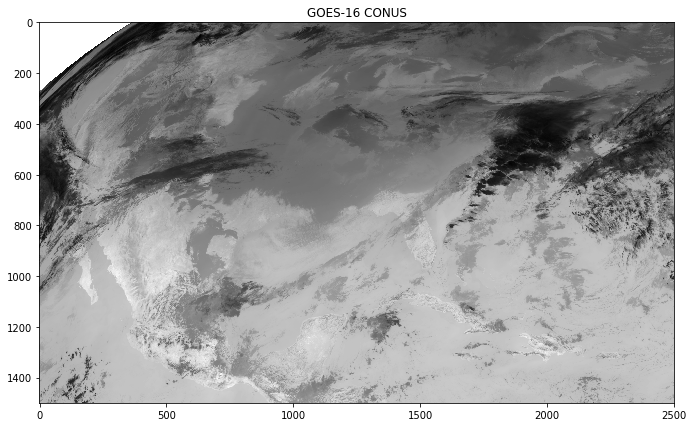

In [26]:
plt.figure(figsize=(15,7))
plt.imshow(C.Rad,cmap='gray')
plt.title('GOES-16 CONUS');

***
#### ABI (Advanced Baseline Imager) Fixed Grid Coordinate Reference System:
* [GOES-R SERIES PRODUCT DEFINITION AND USERS’ GUIDE](https://data.eol.ucar.edu/datafile/nph-get/558.002/GOES-R_Users_Guide_V5.pdf)
![ABI Fixed Grid](images/ABIgrid.png)
[ABI Fixed Grid diagram](https://github.com/UW-GDA/goes-view/blob/master/images/ABIgrid.png)

***
#### Function for generating a pyproj object (and proj4 string):

In [4]:
def getProj4string(goes_imager_projection):
    '''make a proj4 string  and a pyproj geostationary map object from goes imager projection information'''
    
    h=goes_imager_projection.perspective_point_height #          Satellite height above ellipsoid
    a=goes_imager_projection.semi_major_axis #                   Ellipsoid semi-major axis
    rf=goes_imager_projection.inverse_flattening #               Ellipsoid flattening (describes semi-minor axis)
    lon0=goes_imager_projection.longitude_of_projection_origin # Center longitude (GOES-East ~ -75.5)
    lat0=goes_imager_projection.latitude_of_projection_origin #  Center latitude (0.0)
    sweep=goes_imager_projection.sweep_angle_axis #              "Sweep angle" axis (x)
    
    # Make proj4 string
    proj_string = '"+proj=geos +ellps=GRS80 +h={h} +a={a} +rf={rf} +lon_0={lon0} +lat_0={lat0} +sweep={sweep}"'.format(
        h=h,a=a,rf=rf,lon0=lon0,lat0=lat0,sweep=sweep)
    
    # Use pyproj to define
    p = Proj(proj='geos', h=h, lon_0=lon0, sweep=sweep)
    
    return proj_string, p

In [28]:
# make a proj4 string and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C.goes_imager_projection)

#### Function to convert ABI fixed grid coordinates into Lat, Lon:

In [5]:
def getLatLon(sat_x,sat_y,sat_h,R,p):
    
    # See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
    x = sat_x * sat_h
    y = sat_y * sat_h
    
    # Perform cartographic transformation:
    # convert image projection coordinates (x and y) to latitude and longitude values
    XX, YY = np.meshgrid(x, y)
    lons, lats = p(XX, YY, inverse=True)

    # Assign the pixels showing space as a single point in the Gulf of Alaska
    lats[np.isnan(R)] = 57
    lons[np.isnan(R)] = -152
    
    # Replace in radiance values nans
    R[np.isnan(R)] = -9999.0
    
    return lats, lons, R

In [32]:
# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
sat_h = C.goes_imager_projection.perspective_point_height
sat_x = C['x'][:]
sat_y = C['y'][:]
Rad = C['Rad'].data

lats16, lons16, R16 = getLatLon(sat_x,sat_y,sat_h,Rad,p)


***
#### Alternate function to manually calculate lat/lon coordinates:

In [29]:
def ABIangle2LatLon(x, y, H, req, rpol, lon_0):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0 - np.arctan( Sy / ( H - Sx ))
    
    return (lat,lon)

#* There was a typo here in the PUG document, latitude needs to be converted from radians to degrees, 
#  whereas latitude was already in degrees.

In [ ]:
# make a 2d array of both x and y in radians
x, y = np.meshgrid(c14.x.values, c14.y.values)

# Values needed for geometry calculations
req = c14.goes_imager_projection.semi_major_axis # semi major axis
rpol = c14.goes_imager_projection.semi_minor_axis
H = c14.goes_imager_projection.perspective_point_height + c14.goes_imager_projection.semi_major_axis
lon_0 = c14.goes_imager_projection.longitude_of_projection_origin

# Get lat and lon values
lat, lon = ABIangle2LatLon(x,y,H,req,rpol,lon_0)

***
#### Create a map object for plotting:

In [12]:
# Use an orthographic projection
mL = Basemap(resolution='i', projection='ortho', 
              lat_0=35, lon_0=-100)

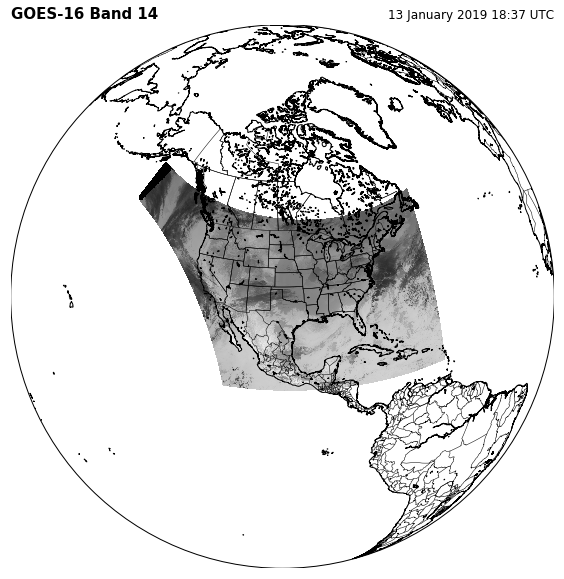

In [13]:
plt.figure(figsize=[10, 10])

# Plotting radiances on our map
newmap = mL.pcolormesh(lons16, lats16, R16, cmap='gray', vmin=0, linewidth=0, latlon=True)

mL.drawcoastlines()
mL.drawcountries()
mL.drawstates()

plt.title('GOES-16 Band 14', loc='left', fontweight='semibold', fontsize=15)
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ') # Scan's start time, converted to datetime object
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');
plt.savefig('images/GOES-16_b14.png')

***
#### Repeat the same to add GOES-17 to the plot:

In [14]:
# select the GOES-17 path
bucket_n = 1
file_list = os.listdir(filepath[bucket_n])

# pick a file from this list
file_n = 0
file = filepath[bucket_n] + file_list[file_n]

# open dataset using xarray
C_17 = xr.open_dataset(filepath[bucket_n] + file_list[0])

In [15]:
# make a proj4 string  and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C_17.goes_imager_projection)


# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
sat_h = C_17.goes_imager_projection.perspective_point_height
sat_x = C_17['x'][:]
sat_y = C_17['y'][:]
Rad = C_17['Rad'].data

lats17, lons17, R17 = getLatLon(sat_x,sat_y,sat_h,Rad,p)


In [16]:
# Or use an orthographic projection
mL = Basemap(resolution='i', projection='ortho', 
              lat_0=35, lon_0=-120)

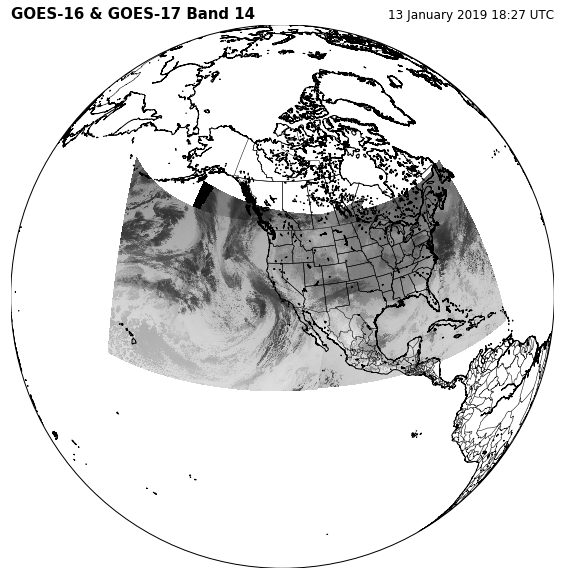

In [17]:
plt.figure(figsize=[10, 10])

# Plotting radiances on our map
g16 = mL.pcolormesh(lons16, lats16, R16, cmap='gray',vmin=0, linewidth=0, latlon=True)
g17 = mL.pcolormesh(lons17, lats17, R17, cmap='gray',vmin=0, linewidth=0, latlon=True)

mL.drawcoastlines()
mL.drawcountries()
mL.drawstates()

plt.title('GOES-16 & GOES-17 Band 14', loc='left', fontweight='semibold', fontsize=15)
scan_start = datetime.strptime(C_17.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ') # Scan's start time, converted to datetime object
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');
plt.savefig('images/GOES-16-17_b14.png')

#### Make a closeup plot of the Sierra Nevada:
This time using higher resolution (~1km) NIR band

In [19]:
# Load a higher resolution band (band 3, NIR)

# AWS S3 Buckets to search for GOES-16 and -17
buckets = ['noaa-goes16','noaa-goes17']
# Specify date, time, product, band (channel)
year='2019'
month='01'
day='13'
hour='18'
product='ABI-L1b-RadC'
channel='C03'
# Local paths where data will be stored
paths = ['/home/jovyan/goes16', '/home/jovyan/goes17'] # or if at home 'C:/Users/steve/goes16'
filepath = []; # store filepaths of the files we download

In [20]:
# For each S3 bucket, download the corresponding observations
for i in range(len(buckets)):
    filepath.append('{}/{}/{}/{}/{}/{}/{}/'.format(paths[i],year,month,day,product,hour,channel))
    if not os.path.exists(filepath[i]):
        ABI = ABI_Downloader(buckets[i],year,month,day,hour,product,channel)

Downloading... the product ABI-L1b-RadC 
OR_ABI-L1b-RadC-M3C03_G16_s20190131857173_e20190131859546_c20190131859589.nc: [##########] 100%  15.747508 MB/15.747508 MBDownloading... the product ABI-L1b-RadC 
OR_ABI-L1b-RadC-M3C03_G17_s20190131857190_e20190131859502_c20190131859535.nc: [##########] 100%  15.59933 MB/15.59933 MB

In [8]:
# select the GOES-16 path
bucket_n = 0
file_list = os.listdir(filepath[bucket_n])

# pick a file from this list
file_n = 0
file = filepath[bucket_n] + file_list[file_n]

# open dataset using xarray
C_16 = xr.open_dataset(filepath[bucket_n] + file_list[0])

# make a proj4 string  and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C_16.goes_imager_projection)

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
sat_h = C_16.goes_imager_projection.perspective_point_height
sat_x = C_16['x'][:]
sat_y = C_16['y'][:]
Rad = C_16['Rad'].data

lats16, lons16, R16 = getLatLon(sat_x,sat_y,sat_h,Rad,p)

In [9]:
# select the GOES-17 path
bucket_n = 1
file_list = os.listdir(filepath[bucket_n])

# pick a file from this list
file_n = 0
file = filepath[bucket_n] + file_list[file_n]

# open dataset using xarray
C_17 = xr.open_dataset(filepath[bucket_n] + file_list[0])

# make a proj4 string  and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C_17.goes_imager_projection)

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
sat_h = C_17.goes_imager_projection.perspective_point_height
sat_x = C_17['x'][:]
sat_y = C_17['y'][:]
Rad = C_17['Rad'].data

lats17, lons17, R17 = getLatLon(sat_x,sat_y,sat_h,Rad,p)

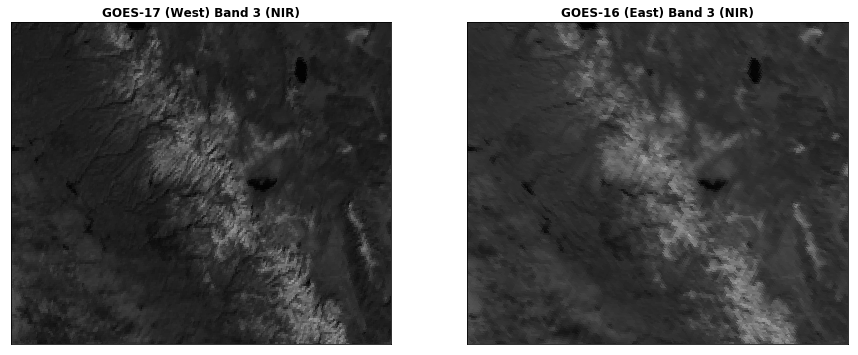

In [10]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=[15, 10])

# Create a map around our area of interest (lower left lon & lat, upper right lon & lat)
sierras_map_17 = Basemap(llcrnrlon=-121,llcrnrlat=37,urcrnrlon=-118,urcrnrlat=39,
             resolution='i', projection='merc', ax=ax1)
sierras_map_16 = Basemap(llcrnrlon=-121,llcrnrlat=37,urcrnrlon=-118,urcrnrlat=39,
             resolution='i', projection='merc', ax=ax2)


# GOES-17 (West)
g17 = sierras_map_17.pcolormesh(lons17, lats17, R17, cmap='gray',vmin=0, vmax=300, linewidth=0, latlon=True)
ax1.set_title('GOES-17 (West) Band 3 (NIR)', loc='center', fontweight='semibold', fontsize=12);

# GOES-16 (East)
g16 = sierras_map_16.pcolormesh(lons16, lats16, R16, cmap='gray',vmin=0, vmax=300, linewidth=0, latlon=True)
ax2.set_title('GOES-16 (East) Band 3 (NIR)', loc='center', fontweight='semibold', fontsize=12);


In [24]:
# Save each subplot
extent = ax1.get_window_extent().transformed(f.dpi_scale_trans.inverted())
f.savefig('images/GOES-17_NIR.png', bbox_inches=extent.expanded(1.1, 1.1))
extent = ax2.get_window_extent().transformed(f.dpi_scale_trans.inverted())
f.savefig('images/GOES-16_NIR.png', bbox_inches=extent.expanded(1.1, 1.1))